In [42]:
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, Naive

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot

from functools import partial
from IPython.display import Image
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series as plot_series_utils
import pandas as pd
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from utils.calculations import process_df

In [12]:
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)

In [ ]:
df = arrivals_dataset.get_data_without_missing_values()


df_rj = process_df(
    df=df, 
    state="rio_de_janeiro", 
    agg_cols=["date", "continent", "country"], 
    value_cols="arrivals", 
    agg_func="sum"
)



In [58]:
#remover outros paises
df_rj = df_rj[df_rj['country'] != 'outros_paises']
df_rj['country'].unique()


array(['africa_do_sul', 'angola', 'nigeria', 'costa_rica', 'panama',
       'porto_rico', 'canada', 'estados_unidos', 'mexico', 'argentina',
       'bolivia', 'chile', 'colombia', 'equador', 'guiana',
       'guiana_francesa', 'paraguai', 'peru', 'suriname', 'uruguai',
       'venezuela', 'arabia_saudita', 'china', 'iraque', 'israel',
       'japao', 'republica_da_coreia', 'alemanha', 'austria', 'belgica',
       'dinamarca', 'espanha', 'franca', 'grecia', 'holanda', 'italia',
       'noruega', 'portugal', 'reino_unido', 'suecia', 'suica',
       'australia', 'nova_zelandia', 'cabo_verde', 'finlandia', 'hungria',
       'irlanda', 'polonia', 'cuba', 'guatemala', 'india',
       'republica_tcheca', 'russia', 'egito', 'gana', 'marrocos',
       'mocambique', 'quenia', 'tunisia', 'el_salvador', 'haiti',
       'honduras', 'nicaragua', 'republica_dominicana',
       'trinidad_e_tobago', 'bangladesh', 'china,_hong_kong', 'cingapura',
       'filipinas', 'indonesia', 'ira', 'libano', 'malasi

In [59]:
spec = [
    ["continent"],
    ["continent", "country"]
]

df_rj_agg = df_rj.rename(columns={'date': 'ds', 'arrivals': 'y'})

Y_df, S_df, tags = aggregate(df=df_rj_agg, spec=spec)

In [62]:
Y_df['unique_id'].unique()

array(['africa', 'america_central_e_caribe', 'america_do_norte',
       'america_do_sul', 'asia', 'europa', 'oceania',
       'africa/africa_do_sul', 'africa/angola', 'africa/cabo_verde',
       'africa/egito', 'africa/gana', 'africa/marrocos',
       'africa/mocambique', 'africa/nigeria',
       'africa/outros_paises_da_africa', 'africa/quenia',
       'africa/tunisia', 'america_central_e_caribe/costa_rica',
       'america_central_e_caribe/cuba',
       'america_central_e_caribe/el_salvador',
       'america_central_e_caribe/guatemala',
       'america_central_e_caribe/haiti',
       'america_central_e_caribe/honduras',
       'america_central_e_caribe/nicaragua',
       'america_central_e_caribe/outros_paises_da_america_central_e_caribe',
       'america_central_e_caribe/panama',
       'america_central_e_caribe/porto_rico',
       'america_central_e_caribe/republica_dominicana',
       'america_central_e_caribe/trinidad_e_tobago',
       'america_do_norte/canada', 'america_do_norte

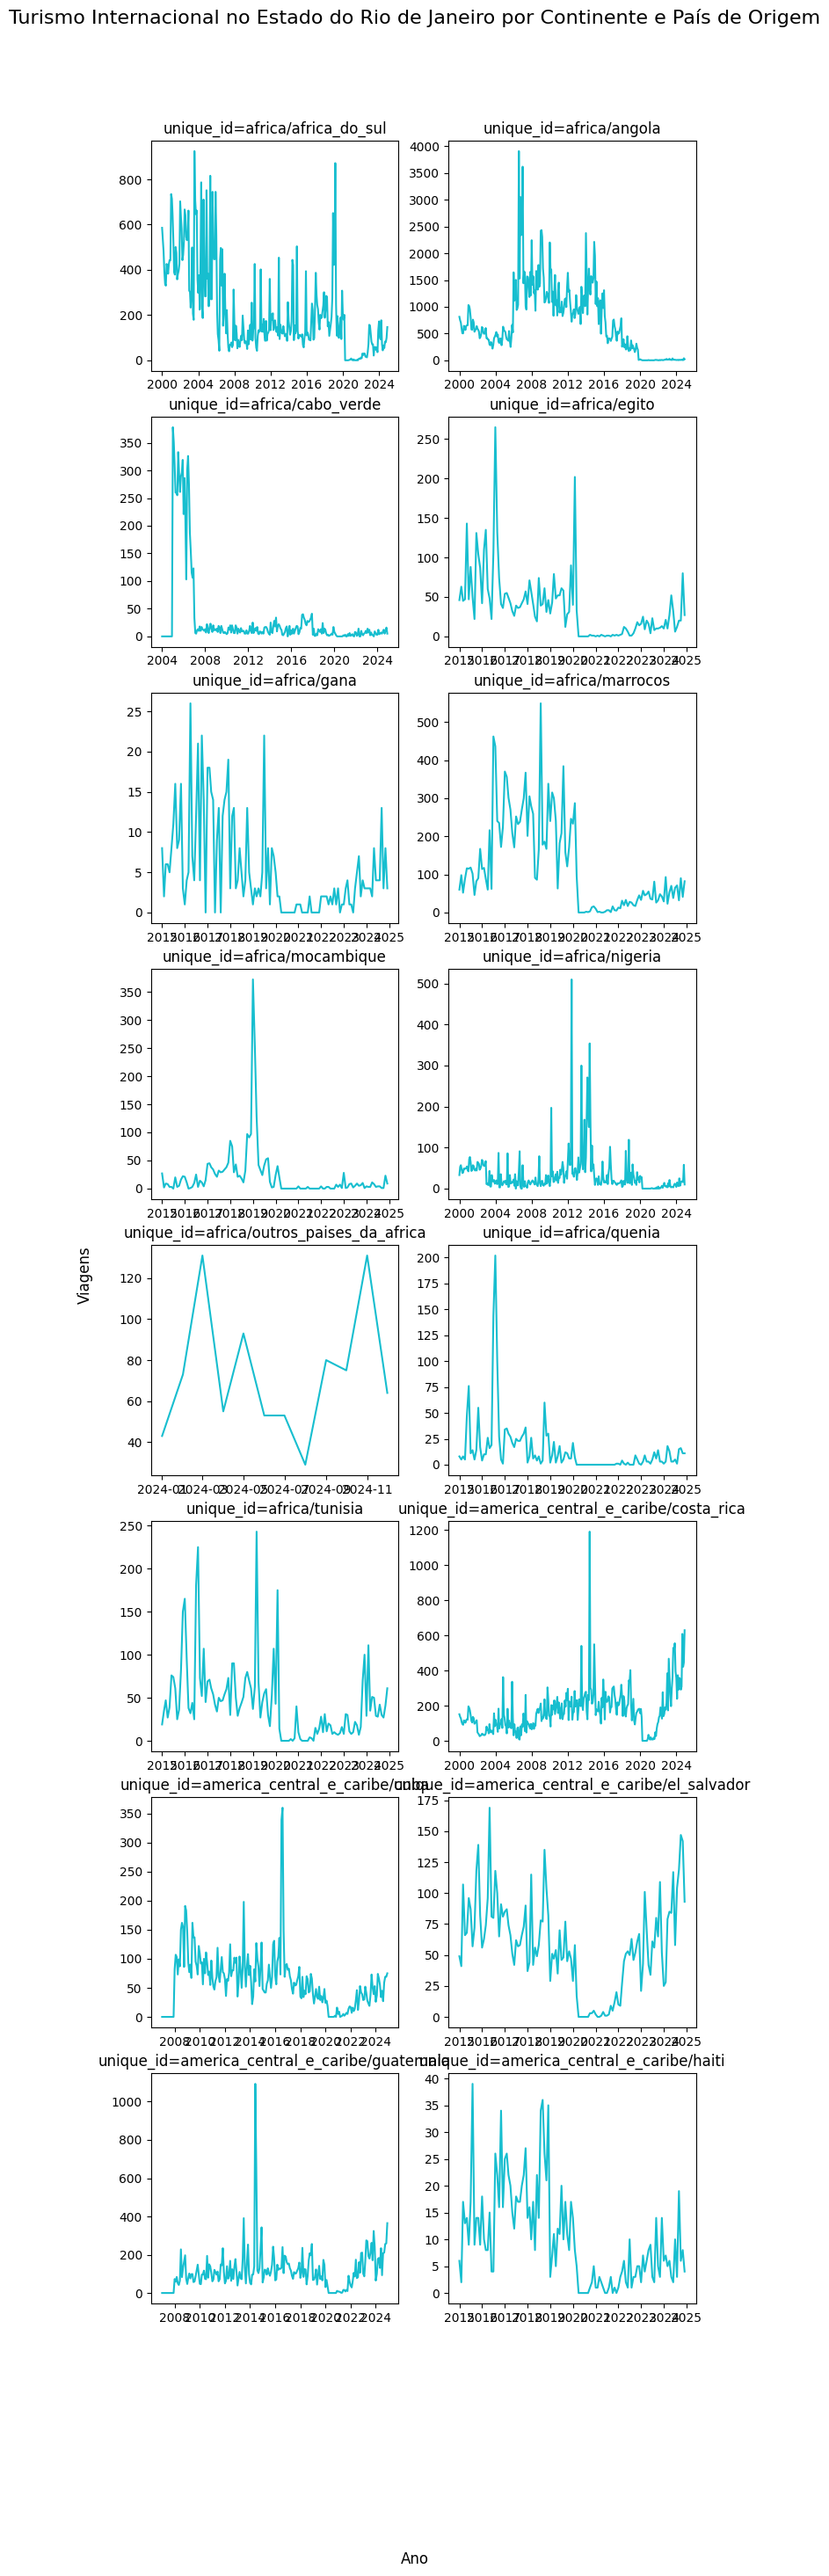

In [65]:
states = list(tags["continent/country"])

_, axes = plt.subplots(nrows=8, ncols=2, figsize=(8, 30))
fig = plot_series_utils(Y_df[Y_df['unique_id'].isin(states)].reset_index(), plot_random=False, max_ids=8, ax=axes)
for ax in fig.axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both')
    if ax.get_legend():
        ax.get_legend().remove()
    for label in ax.get_xticklabels():
        label.set_rotation(0)
fig.legends = []
fig.suptitle("Turismo Internacional no Estado do Rio de Janeiro por Continente e País de Origem", fontsize=16)
fig.supylabel("Viagens")
fig.supxlabel("Ano")
fig.subplots_adjust(top=0.93)
fig

Período da Covid-19

In [69]:
PRE_COVID_END = '2020-02-29' # Último dia antes do impacto
COVID_START = '2020-03-01' # Primeiro dia do impacto
COVID_END = '2023-05-01'   # Último dia do período a ser imputado

Imputação com a decomposição STL

In [84]:
from statsmodels.tsa.seasonal import STL

# Filtrar o DataFrame para o período de treinamento (pré-COVID)
Y_train_df = Y_df[Y_df['ds'] <= PRE_COVID_END]

# Definir o horizonte de previsão
start_date = pd.to_datetime(COVID_START)
end_date = pd.to_datetime(COVID_END)
h = len(pd.date_range(start=COVID_START, end=COVID_END, freq='MS'))

Y_train_df = Y_df[Y_df['ds'] <= PRE_COVID_END]

# DataFrame para armazenar os resultados da imputação STL
Y_df_STL = Y_df.copy()

# Iterar sobre cada série temporal única
for uid in Y_df['unique_id'].unique():
    # Filtrar os dados de treinamento (pré-COVID) para a série atual
    serie_train = Y_train_df[Y_train_df['unique_id'] == uid].set_index('ds')['y']
    
    # Verificar se a série tem dados suficientes para a decomposição STL
    if len(serie_train) > 24: # STL requer pelo menos 2 ciclos sazonais
        # Decomposição STL
        stl = STL(serie_train, period=12).fit()
        
        # Previsão ingênua da tendência (último valor)
        trend_forecast = stl.trend[-1]
        
        # Repetir o último ciclo sazonal para o horizonte de previsão
        last_season_cycle = stl.seasonal[-(12):]
        seasonal_forecast = pd.concat([last_season_cycle] * ((h // 12) + 1))[:h]
        
        # Combinar tendência e sazonalidade para a imputação
        imputation_values = trend_forecast + seasonal_forecast.values
        
        # Datas para o período de imputação
        imputation_dates = pd.date_range(start=COVID_START, periods=h, freq='MS')
        
        # Filtro para as linhas que serão atualizadas
        update_filter = (Y_df_STL['unique_id'] == uid) & (Y_df_STL['ds'].isin(imputation_dates))
        
        # Número de linhas a serem atualizadas
        num_rows_to_update = update_filter.sum()
        
        # Atualizar o DataFrame com os valores imputados, garantindo que os tamanhos correspondam
        Y_df_STL.loc[update_filter, 'y'] = imputation_values[:num_rows_to_update]

# Garantir que os valores de 'y' não sejam negativos
Y_df_STL['y'] = Y_df_STL['y'].clip(lower=0)

print("Valores do período da COVID-19 substituídos pela tendência + sazonalidade do STL.")
Y_df_STL.head()

C:\Users\Dog\AppData\Local\Temp\ipykernel_19884\467446739.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_forecast = stl.trend[-1]
C:\Users\Dog\AppData\Local\Temp\ipykernel_19884\467446739.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_forecast = stl.trend[-1]
C:\Users\Dog\AppData\Local\Temp\ipykernel_19884\467446739.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_forecast = stl.trend[-1]
C:\Users\D

Valores do período da COVID-19 substituídos pela tendência + sazonalidade do STL.


,unique_id,ds,y
0,africa,2000-01-01,1432.0
1,africa,2000-02-01,1333.0
2,africa,2000-03-01,1243.0
3,africa,2000-04-01,1029.0
4,africa,2000-05-01,882.0


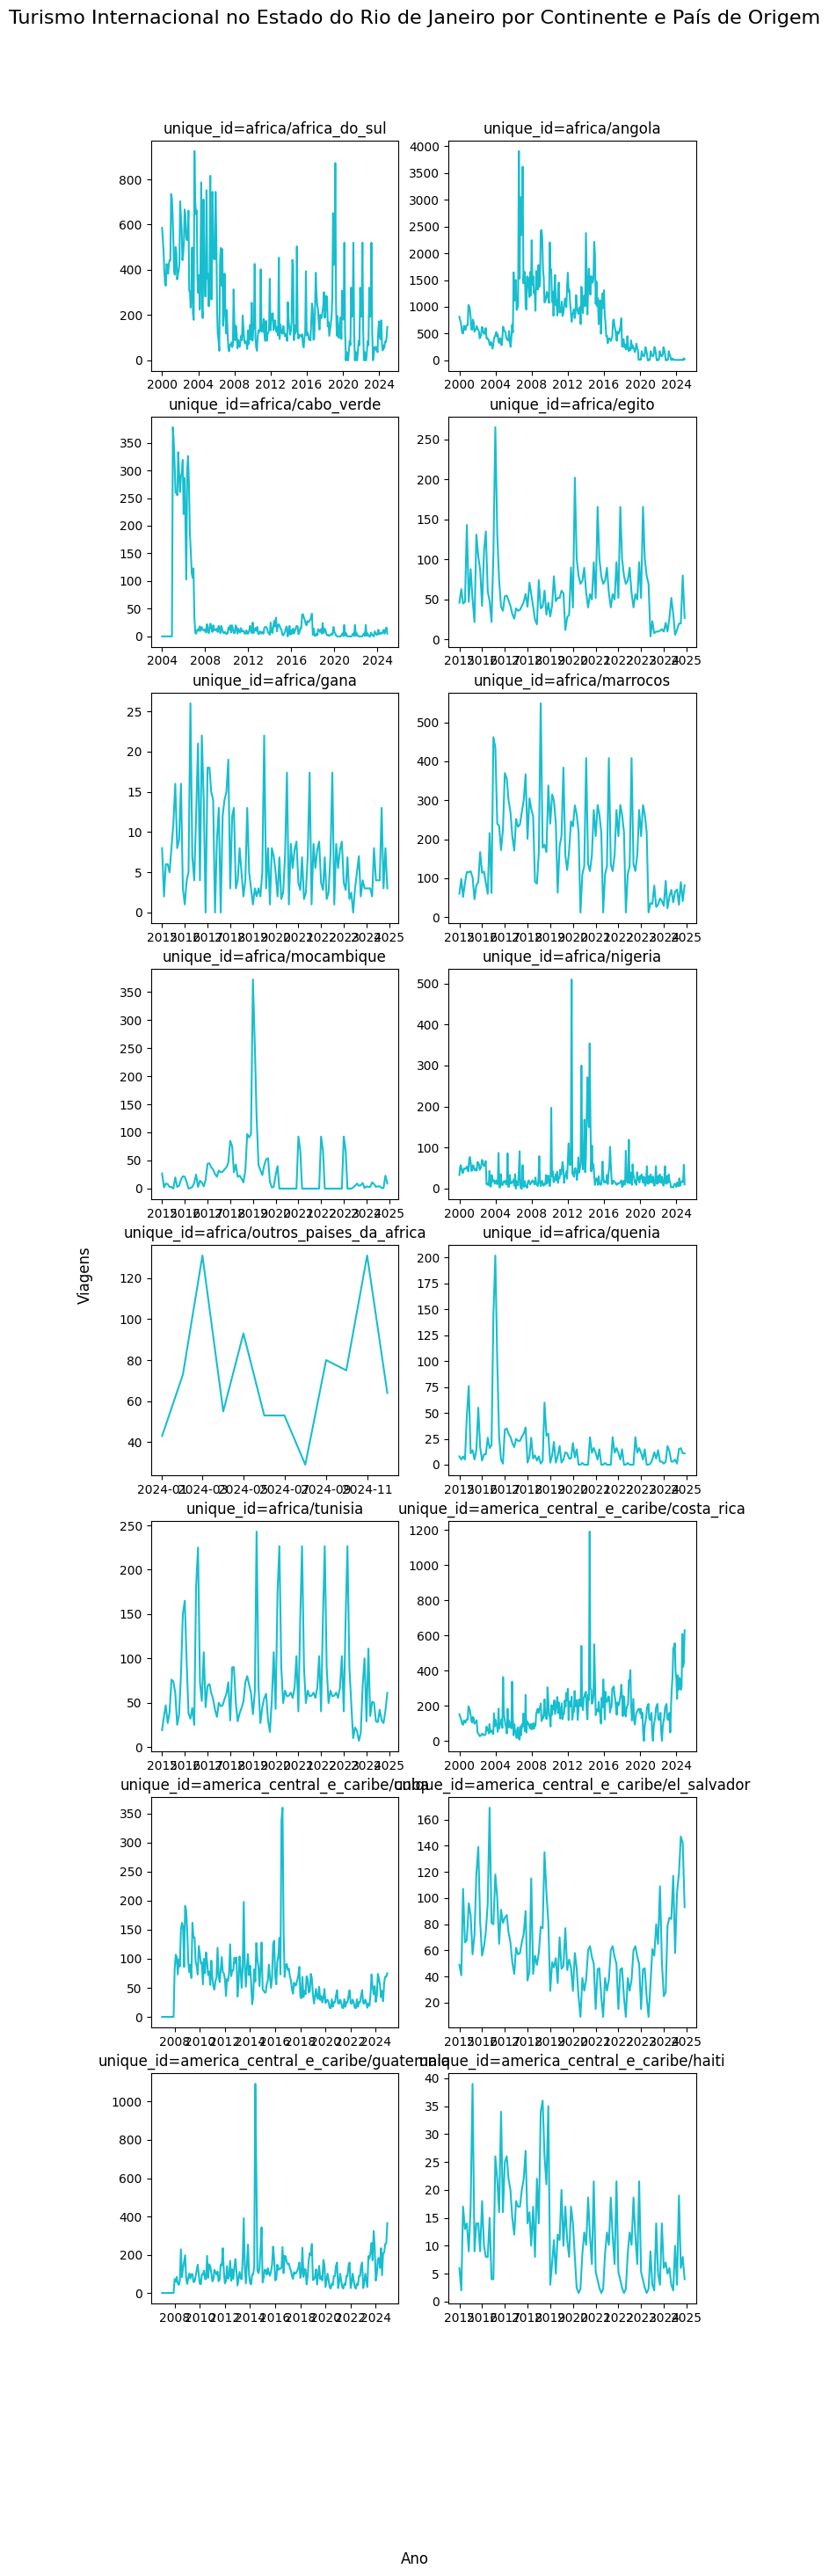

In [85]:
states = list(tags["continent/country"])

_, axes = plt.subplots(nrows=8, ncols=2, figsize=(8, 30))
fig = plot_series_utils(Y_df_STL[Y_df_STL['unique_id'].isin(states)].reset_index(), plot_random=False, max_ids=8, ax=axes)
for ax in fig.axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both')
    if ax.get_legend():
        ax.get_legend().remove()
    for label in ax.get_xticklabels():
        label.set_rotation(0)
fig.legends = []
fig.suptitle("Turismo Internacional no Estado do Rio de Janeiro por Continente e País de Origem", fontsize=16)
fig.supylabel("Viagens")
fig.supxlabel("Ano")
fig.subplots_adjust(top=0.93)
fig

Imputação da Covid-19 pelo AutoETS

In [ ]:
# Filtrar o DataFrame para o período de treinamento (pré-COVID)
Y_train_df = Y_df[Y_df['ds'] <= PRE_COVID_END]

# Definir o horizonte de previsão
start_date = pd.to_datetime(COVID_START)
end_date = pd.to_datetime(COVID_END)
h = len(pd.date_range(start=COVID_START, end=COVID_END, freq='MS'))

# Instanciar e treinar o modelo StatsForecast com AutoETS
sf = StatsForecast(
    models=[AutoETS(season_length=12)],
    freq='MS',
    n_jobs=-1
)
Y_hat_df = sf.forecast(df=Y_train_df, h=h)

# Substituir os valores no período da COVID-19 pelos valores previstos
Y_hat_df = Y_hat_df.rename(columns={'AutoETS': 'y'})
Y_df_covid_imputed = Y_df.set_index(['unique_id', 'ds'])
Y_hat_df = Y_hat_df.set_index(['unique_id', 'ds'])
Y_df_covid_imputed.update(Y_hat_df)
Y_df_ETS = Y_df_covid_imputed.reset_index()

# Garantir que os valores de 'y' não sejam negativos
Y_df['y'] = Y_df['y'].clip(lower=0)

print("Valores do período da COVID-19 substituídos pela previsão do modelo AutoETS.")
Y_df.head()

Valores do período da COVID-19 substituídos pela previsão do modelo AutoETS.


,unique_id,ds,y
0,africa,2000-01-01,1432.0
1,africa,2000-02-01,1333.0
2,africa,2000-03-01,1243.0
3,africa,2000-04-01,1029.0
4,africa,2000-05-01,882.0


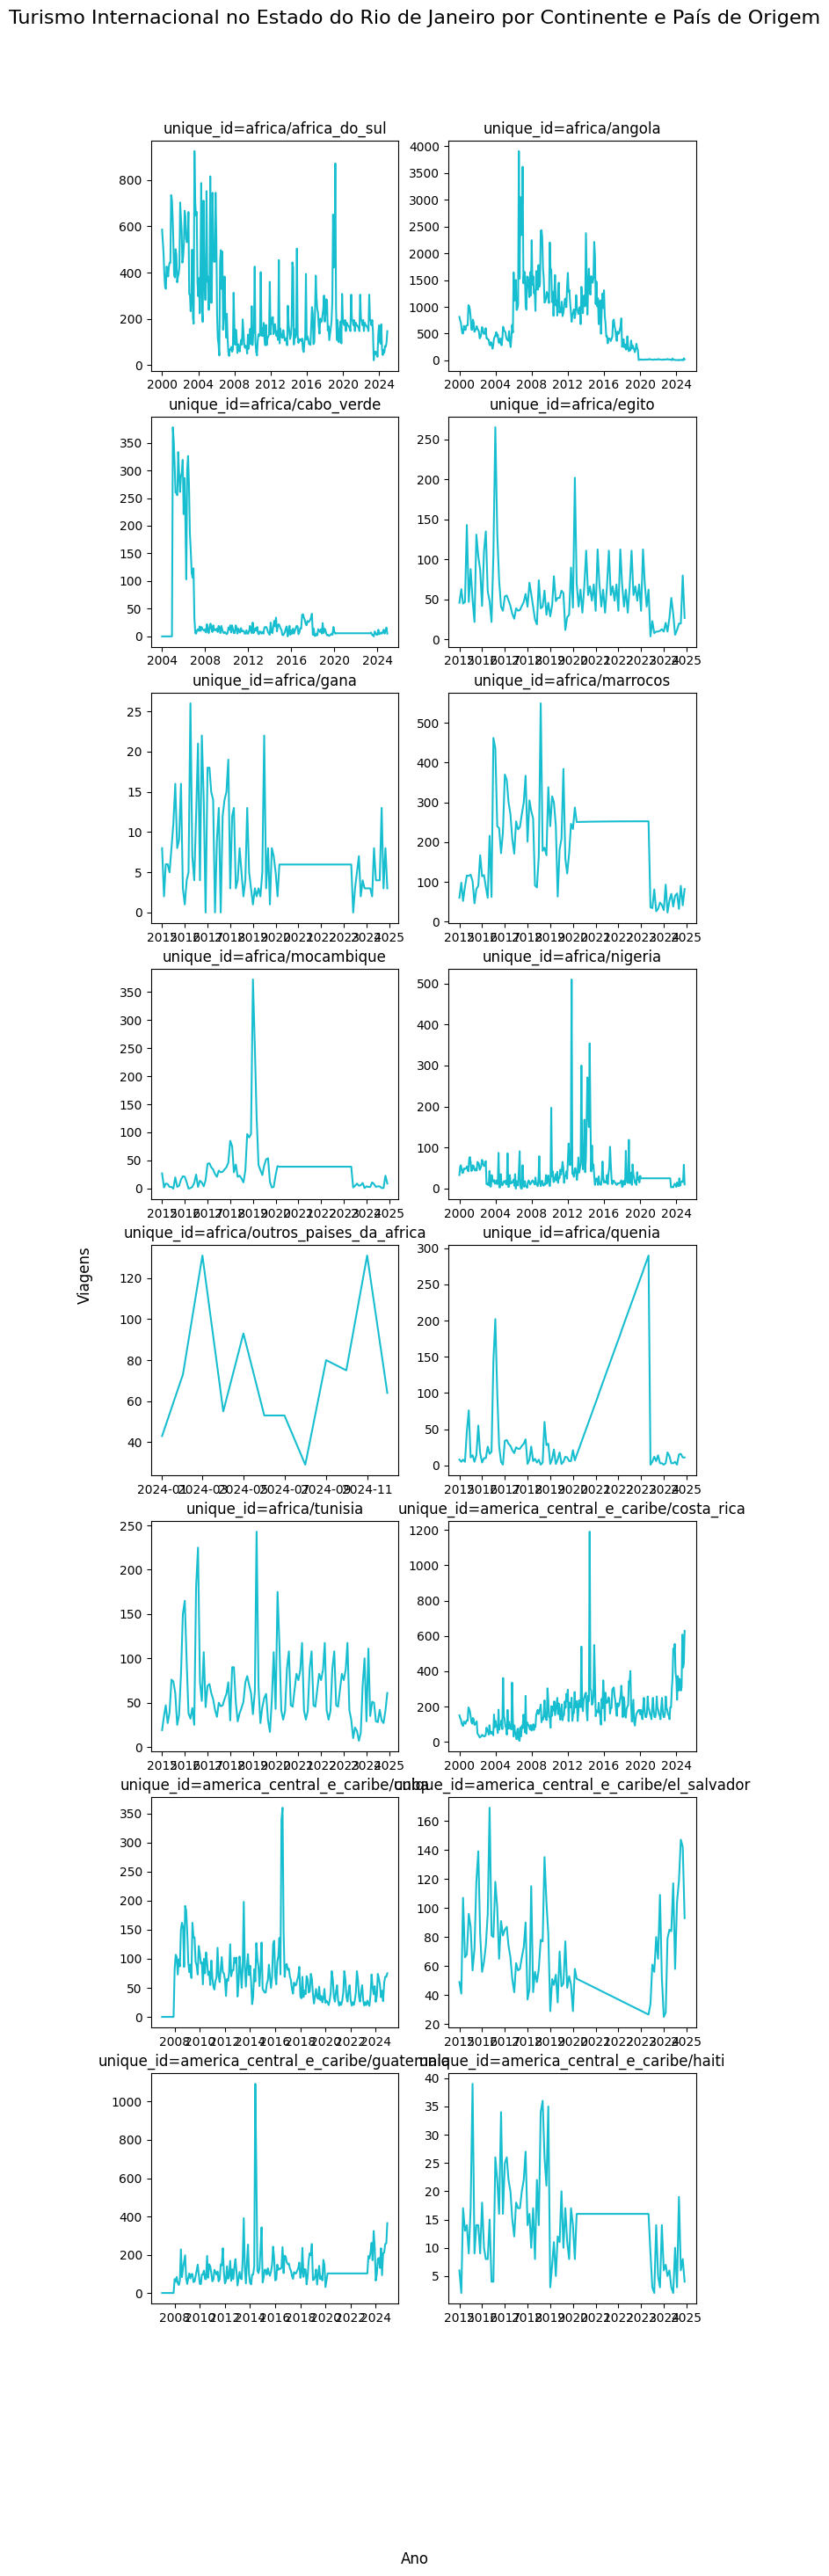

In [73]:
states = list(tags["continent/country"])

_, axes = plt.subplots(nrows=8, ncols=2, figsize=(8, 30))
fig = plot_series_utils(Y_df_ETS[Y_df_ETS['unique_id'].isin(states)].reset_index(), plot_random=False, max_ids=8, ax=axes)
for ax in fig.axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both')
    if ax.get_legend():
        ax.get_legend().remove()
    for label in ax.get_xticklabels():
        label.set_rotation(0)
fig.legends = []
fig.suptitle("Turismo Internacional no Estado do Rio de Janeiro por Continente e País de Origem", fontsize=16)
fig.supylabel("Viagens")
fig.supxlabel("Ano")
fig.subplots_adjust(top=0.93)
fig

In [92]:
Y_train_df = Y_df.query("ds.dt.year <= 2023")
Y_test_df = Y_df.query("ds.dt.year == 2024")

sf = StatsForecast(models=[AutoETS(season_length=12)], freq="MS", n_jobs=-1)

Y_hat_df = sf.forecast(h=12, df=Y_df, fitted=True)
Y_fitted_df = sf.forecast_fitted_values()

reconcilers = [BottomUp(), MinTrace(method="ols"), MinTrace(method="mint_shrink")]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)


C:\Users\Dog\AppData\Local\Temp\ipykernel_19884\2190437935.py:13: DeprecationWarning: The 'S' parameter is deprecated and will be removed in a future version. Please use 'S_df' instead.
  Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)


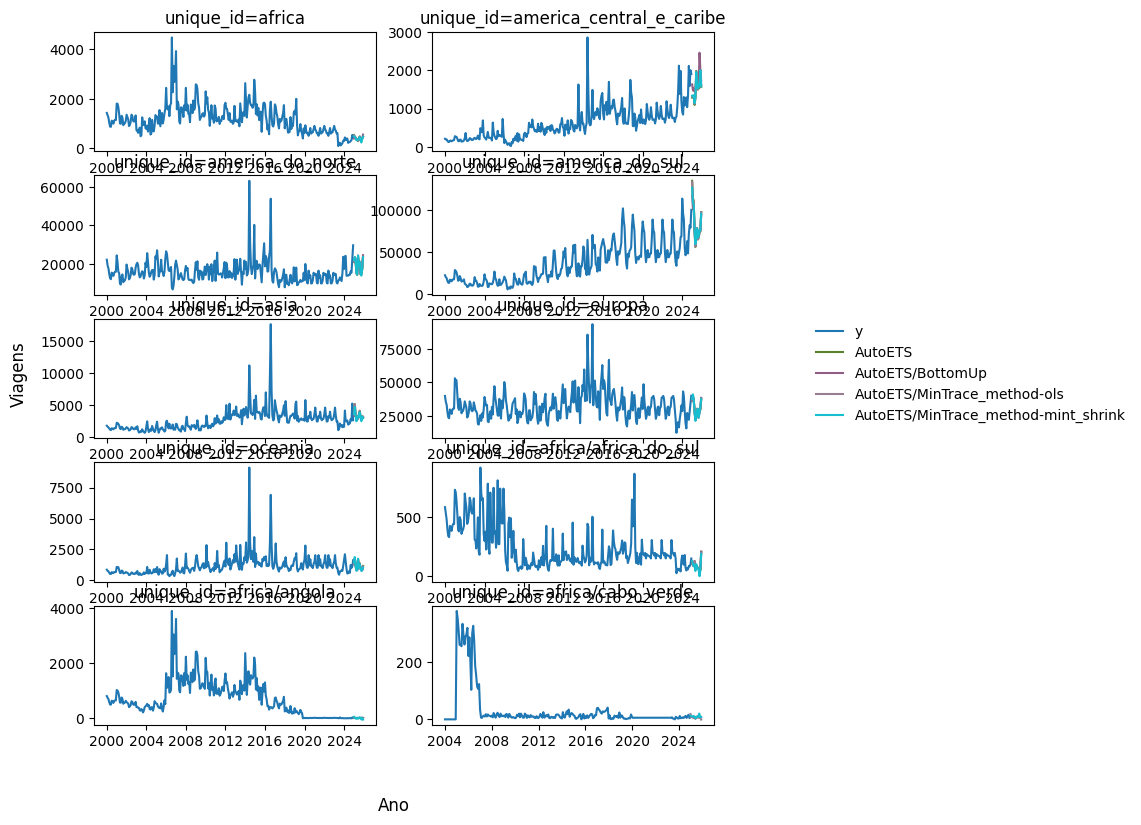

In [94]:
plot_aggs = list(tags["continent"]) + list(tags["continent/country"])

_, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 9))
fig = plot_series_utils(
    df=Y_df.query("unique_id in @plot_aggs and ds.dt.year >= 2000"),
    forecasts_df=Y_rec_df.query(
        "unique_id in @plot_aggs and ds.dt.year >= 2000"
    ),
    plot_random=False,
    max_ids=9,
    ax=axes
)
for ax in fig.axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both')
    if ax.get_legend():
        ax.get_legend().remove()
    for label in ax.get_xticklabels():
        label.set_rotation(0)

fig.supylabel("Viagens")
fig.supxlabel("Ano")
fig.legends = []
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           bbox_to_anchor=(1.02, 0.5),
           loc='center left',
           borderaxespad=0,
           frameon=False)
fig

In [87]:
reconcilers = [BottomUp()]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
sf = StatsForecast(models=[AutoETS(season_length=12)], freq="MS", n_jobs=-1)

Y_hat_df = sf.forecast(h=12, df=Y_df)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_df, S=S_df, tags=tags)
Y_rec_df

C:\Users\Dog\AppData\Local\Temp\ipykernel_19884\1208024440.py:6: DeprecationWarning: The 'S' parameter is deprecated and will be removed in a future version. Please use 'S_df' instead.
  Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_df, S=S_df, tags=tags)


,unique_id,ds,AutoETS,AutoETS/BottomUp
0,africa,2025-01-01,541.873856,400.789702
1,africa,2025-02-01,471.238181,435.958341
2,africa,2025-03-01,437.846457,427.617978
3,africa,2025-04-01,375.450048,401.503405
4,africa,2025-05-01,376.599766,342.668175
...,...,...,...,...
1207,oceania/outros_paises_da_oceania,2025-08-01,3.087813,3.087813
1208,oceania/outros_paises_da_oceania,2025-09-01,3.087813,3.087813
1209,oceania/outros_paises_da_oceania,2025-10-01,3.087813,3.087813
1210,oceania/outros_paises_da_oceania,2025-11-01,3.087813,3.087813
